# Intoduction

The development and success of a company not only depends on attracting new customers but also keeping the existing ones. Therefore, it is vital to investigate what motivates the customers to leave and make predictions accordingly, hence we can take action on those who are likely to drop out to prevent outflow. The telecom-users dataset contains around 6 thousand records of customers from a telecom company. The attributes include demographics of the customers, the services they subscribe to, the billing information, and most importantly, whether the contracts are renewed. The objectives of this notebook are to explore the relations between customers' features and churn and build models to predict whether a customer would leave. The notebook consists of five sections: 
* Import Data and Cleaning
* Explore the Distribution of Target and Features
* Explore the Effects of Features on Target
* Preprocess
* Build Models and Make Prediction

In [1]:

import numpy as np 
import pandas as pd 
from math import floor
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  plot_confusion_matrix, classification_report
%matplotlib inline
sns.set_theme()


# Import Data and Cleaning

In [2]:
# import data from csv file and show the head
df = pd.read_csv('../input/telecom-users-dataset/telecom_users.csv')
df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [3]:
# first take a brief look at data types & non-null counts in each columns
df.info()
# check duplicated entries
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


0

It appears that the first column is redundant. So I am dropping it and set the customerID as the index.
Also, the data type of TotalCharges and SeniorCitizen are changed to make further inspection easier. 

In [4]:
# drop Unnamed: 0 and set customerID as index
df.drop('Unnamed: 0',axis = 1, inplace = True)
df.set_index('customerID',inplace = True)
# change the data types of TotalCharges and SeniorCitizen 
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5986 entries, 7010-BRBUU to 4795-UXVCJ
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   SeniorCitizen     5986 non-null   object 
 2   Partner           5986 non-null   object 
 3   Dependents        5986 non-null   object 
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   object 
 6   MultipleLines     5986 non-null   object 
 7   InternetService   5986 non-null   object 
 8   OnlineSecurity    5986 non-null   object 
 9   OnlineBackup      5986 non-null   object 
 10  DeviceProtection  5986 non-null   object 
 11  TechSupport       5986 non-null   object 
 12  StreamingTV       5986 non-null   object 
 13  StreamingMovies   5986 non-null   object 
 14  Contract          5986 non-null   object 
 15  PaperlessBilling  5986 non-null   object 
 16  PaymentMethod     5986 non-null 

There are 10 entries with null TotalCharges, from the column names we can infer that TotalCharges could be tenure * MonthlyCharges. So let's make a scatter plot to see if it's the case. 


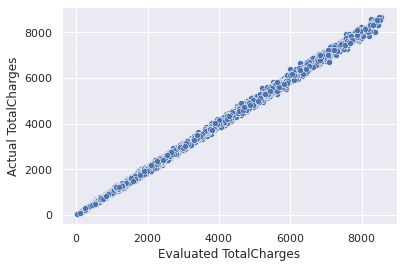

In [5]:
eval_TotalCharges = df.tenure * df.MonthlyCharges
ax = sns.scatterplot(x = eval_TotalCharges,y = df.TotalCharges )
ax.set(xlabel = 'Evaluated TotalCharges',ylabel ='Actual TotalCharges' )
#after seeing the scatter plort, i think it's now safe to fill null TotalCharges with tenure * MonthlyCharges
df['TotalCharges'].fillna(df.tenure * df.MonthlyCharges,inplace = True)

# Explore the Distribution of Target and Features

**First take a look at the target variable.**

<AxesSubplot:xlabel='Churn', ylabel='count'>

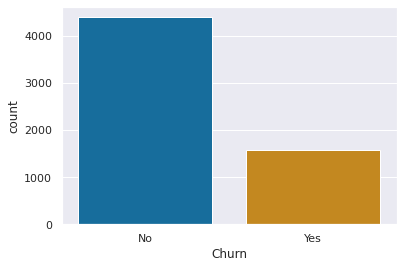

In [6]:
# set the palette to colorblind-friendly style
sns.set_palette('colorblind')
sns.countplot(data = df, x = 'Churn')

**Distribution of numeric features**

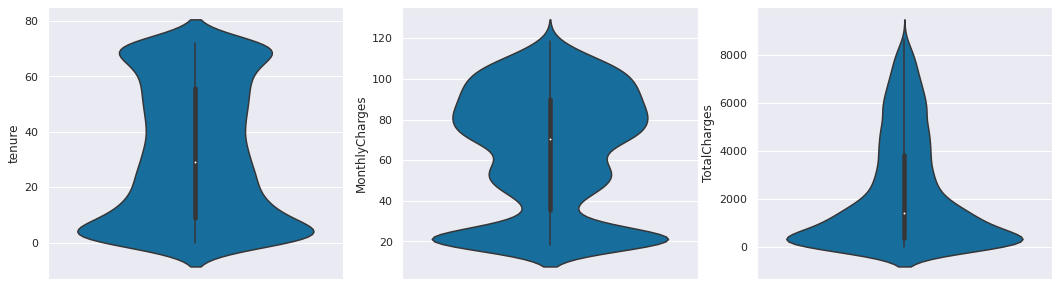

In [7]:
# extract numeric and categorical columns
num_cols = df.columns[df.dtypes!='object']
non_num_cols = df.columns[(df.dtypes=='object') & (df.columns!='Churn')]

fig, axes = plt.subplots(1,3,figsize=(18, 5))
for i,col in enumerate(num_cols):
    sns.violinplot(ax = axes[i], y = df[col])

**Distribution of categorical features**

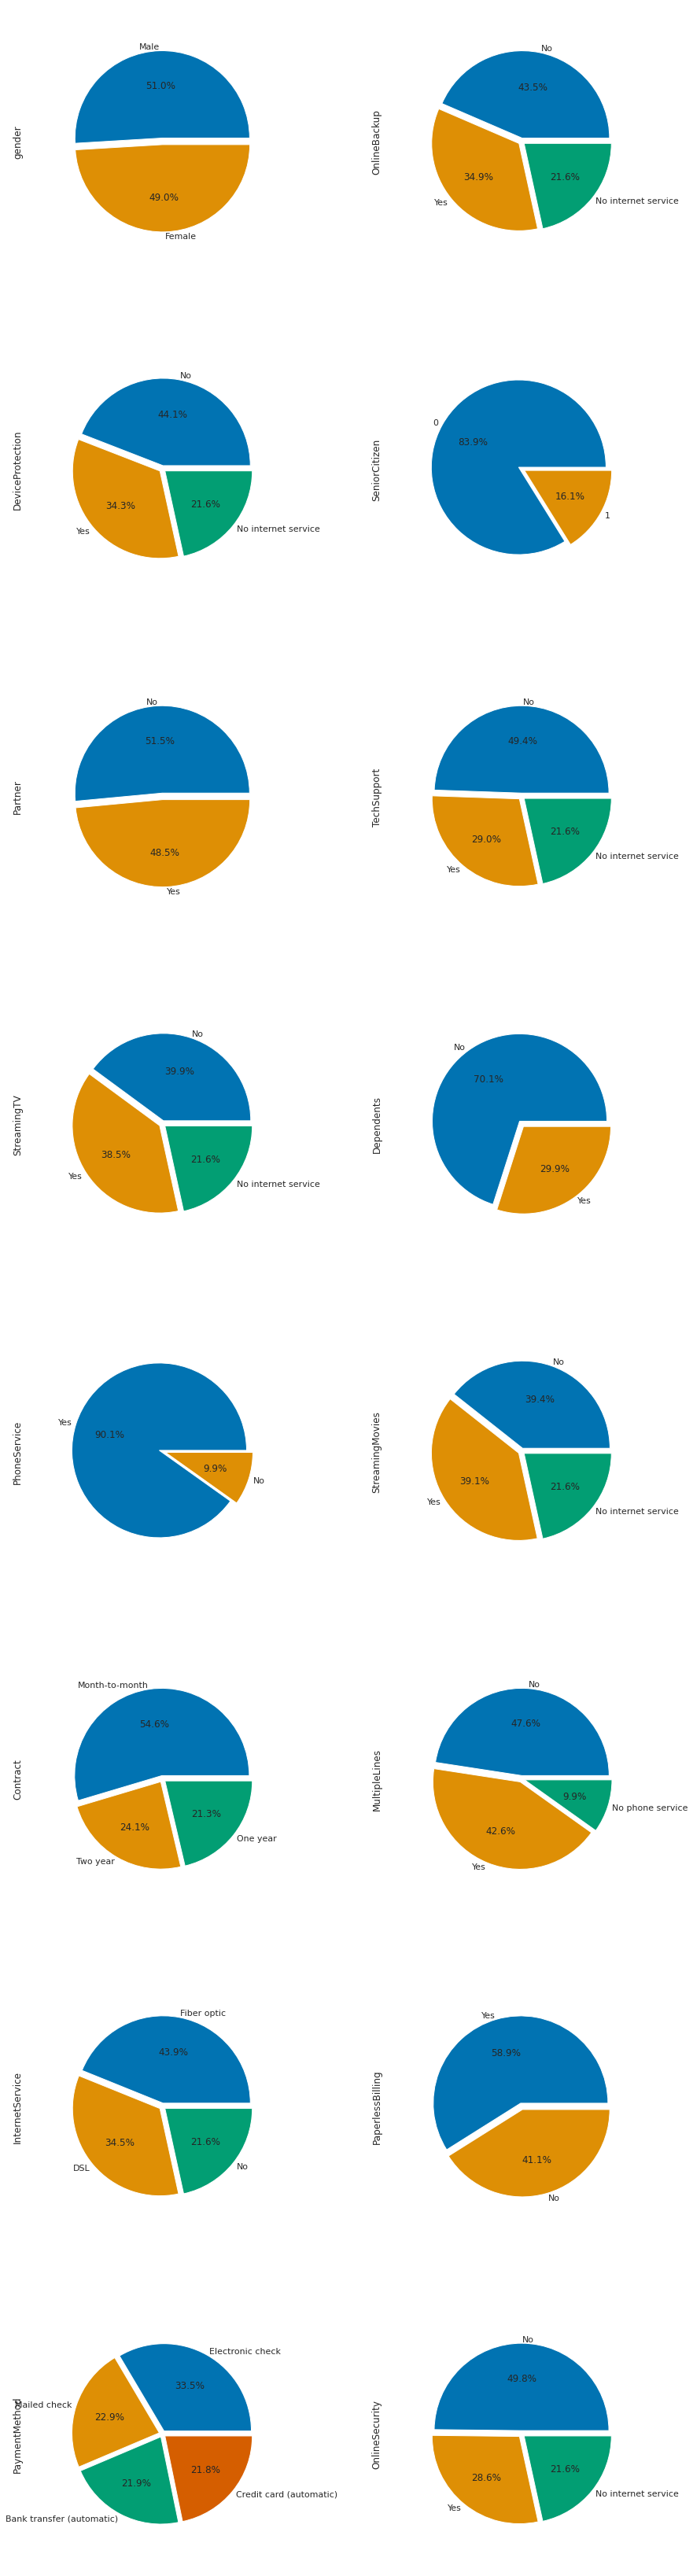

In [8]:
fig, axes = plt.subplots(8,2,figsize=(15,60))
for i,col in enumerate(non_num_cols):
    plt_col = (i+floor(i/8))%2
    plt_row = i%8
    counts = df[col].value_counts()
    counts.plot.pie(ax = axes[plt_row,plt_col],explode=[0.03]*df[col].nunique(),autopct="%.1f%%",labeldistance = 1.05,radius = 0.8)

It seems that the dataset is pretty clean already. There are no unreasonable outliers or categories that are irrelevant to the column names. So we are good to move on to the next section without further cleaning.

# Explore the Effects of Features on Target

**Effects of numeric features**

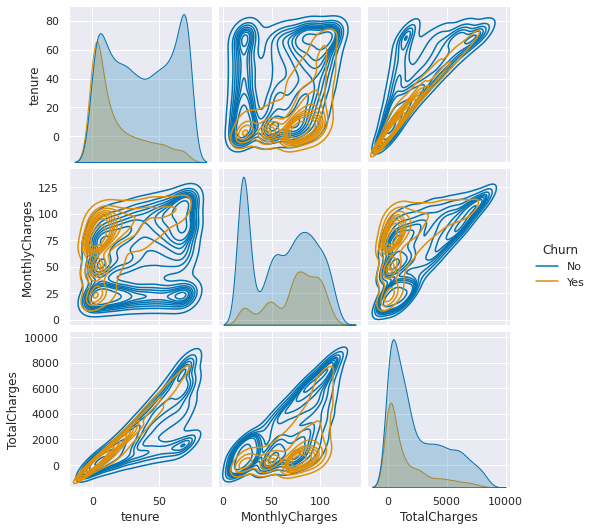

In [9]:
sns.pairplot(df,vars =num_cols, hue = "Churn",kind = 'kde')

* The first pattern observed is that clients are most likely to drop out within the first couple of months. 
* And this is particularly the case for those who received expensive bills right after signing up. We can find the densest churn where the monthly charges are above 70 and the tenure is close to 0.

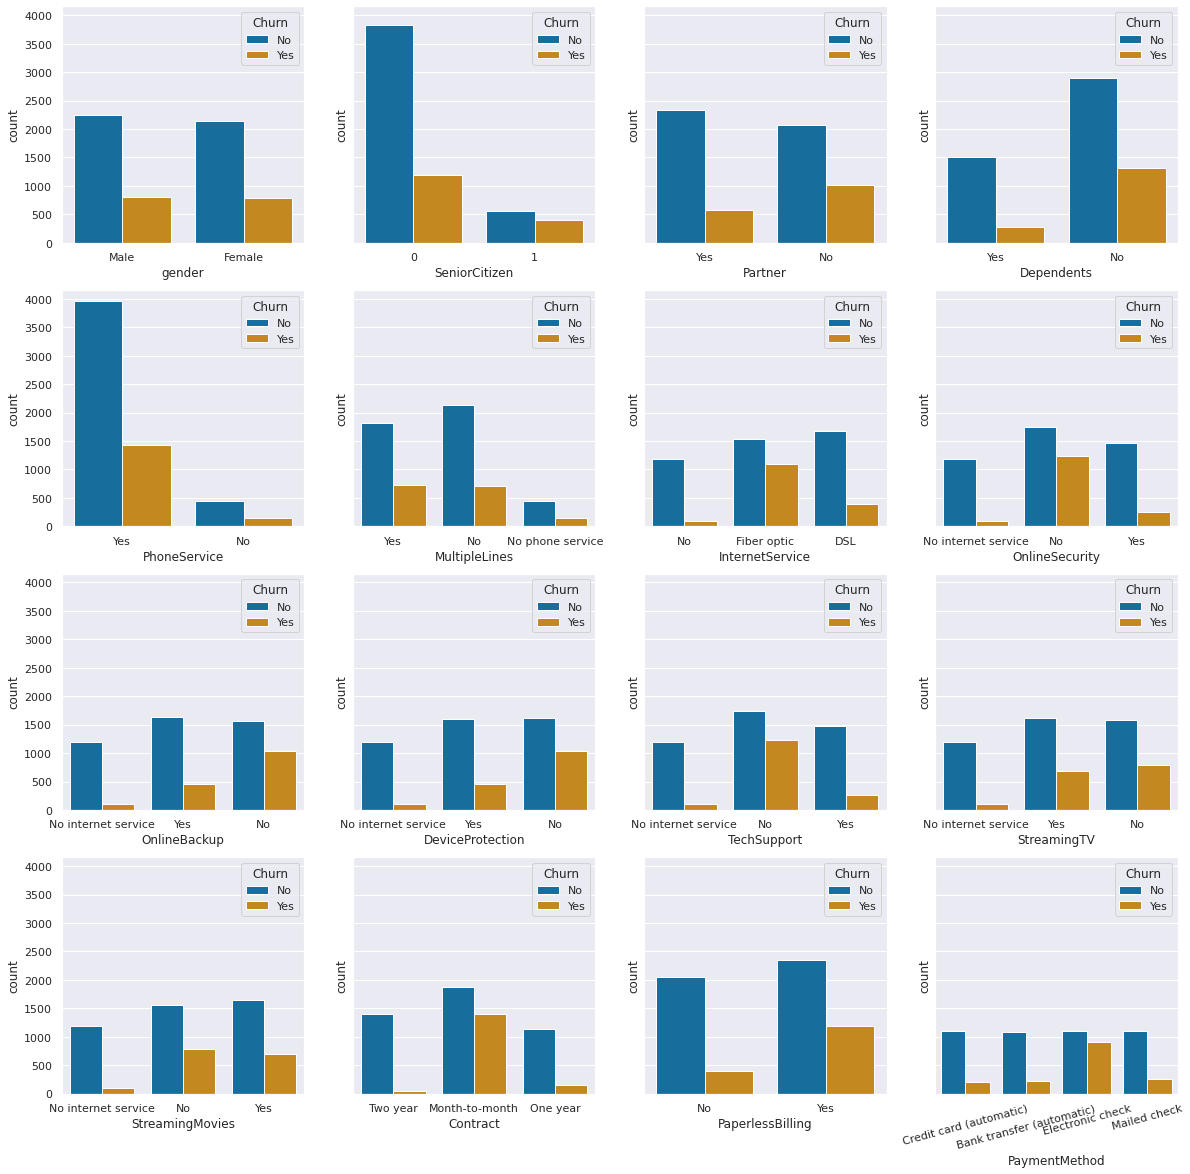

In [10]:
#df.groupby('Churn').gender.value_counts().plot(kind = 'bar)
fig, axes = plt.subplots(4,4,figsize=(20, 20),sharey = True)
#df.groupby('Churn').tenure.hist(alpha = 0.7,legend = True,bins = 20)
for i,col in enumerate(non_num_cols):
    plt_col = i%4
    plt_row = floor(i/4)
    chart = sns.countplot(ax =axes[plt_row,plt_col],x= col ,hue = 'Churn' ,data = df)
    if df[col].astype(str).str.len().max()>20:
        chart.set_xticklabels(chart.get_xticklabels(), rotation=15)

* demographics have little impact on target 
* Under the condition that internet service is subscribed, clients who subscribe to additional services are more likely to stay.
* Month-to-Month contracts make it easier to change service providers.

# **Preprocess**

Before fitting data into the models, we need to transform categorical data into numeric. As most categories are not ordinal, one-hot encoding will be applied instead of integer encoding.

In [11]:
# keep drop_first argument false, and manually select redundant dummies to drop and keep the relevant ones
df_dummies = pd.get_dummies(df)
df_dummies.drop(df_dummies.columns[df_dummies.columns.str.endswith('No internet service')],axis=1,inplace = True)
df_dummies.drop(['gender_Male', 'SeniorCitizen_0', 'Partner_No', 'Dependents_No', 'PhoneService_No','PaperlessBilling_No','Churn_No'],axis=1,inplace = True)

<AxesSubplot:>

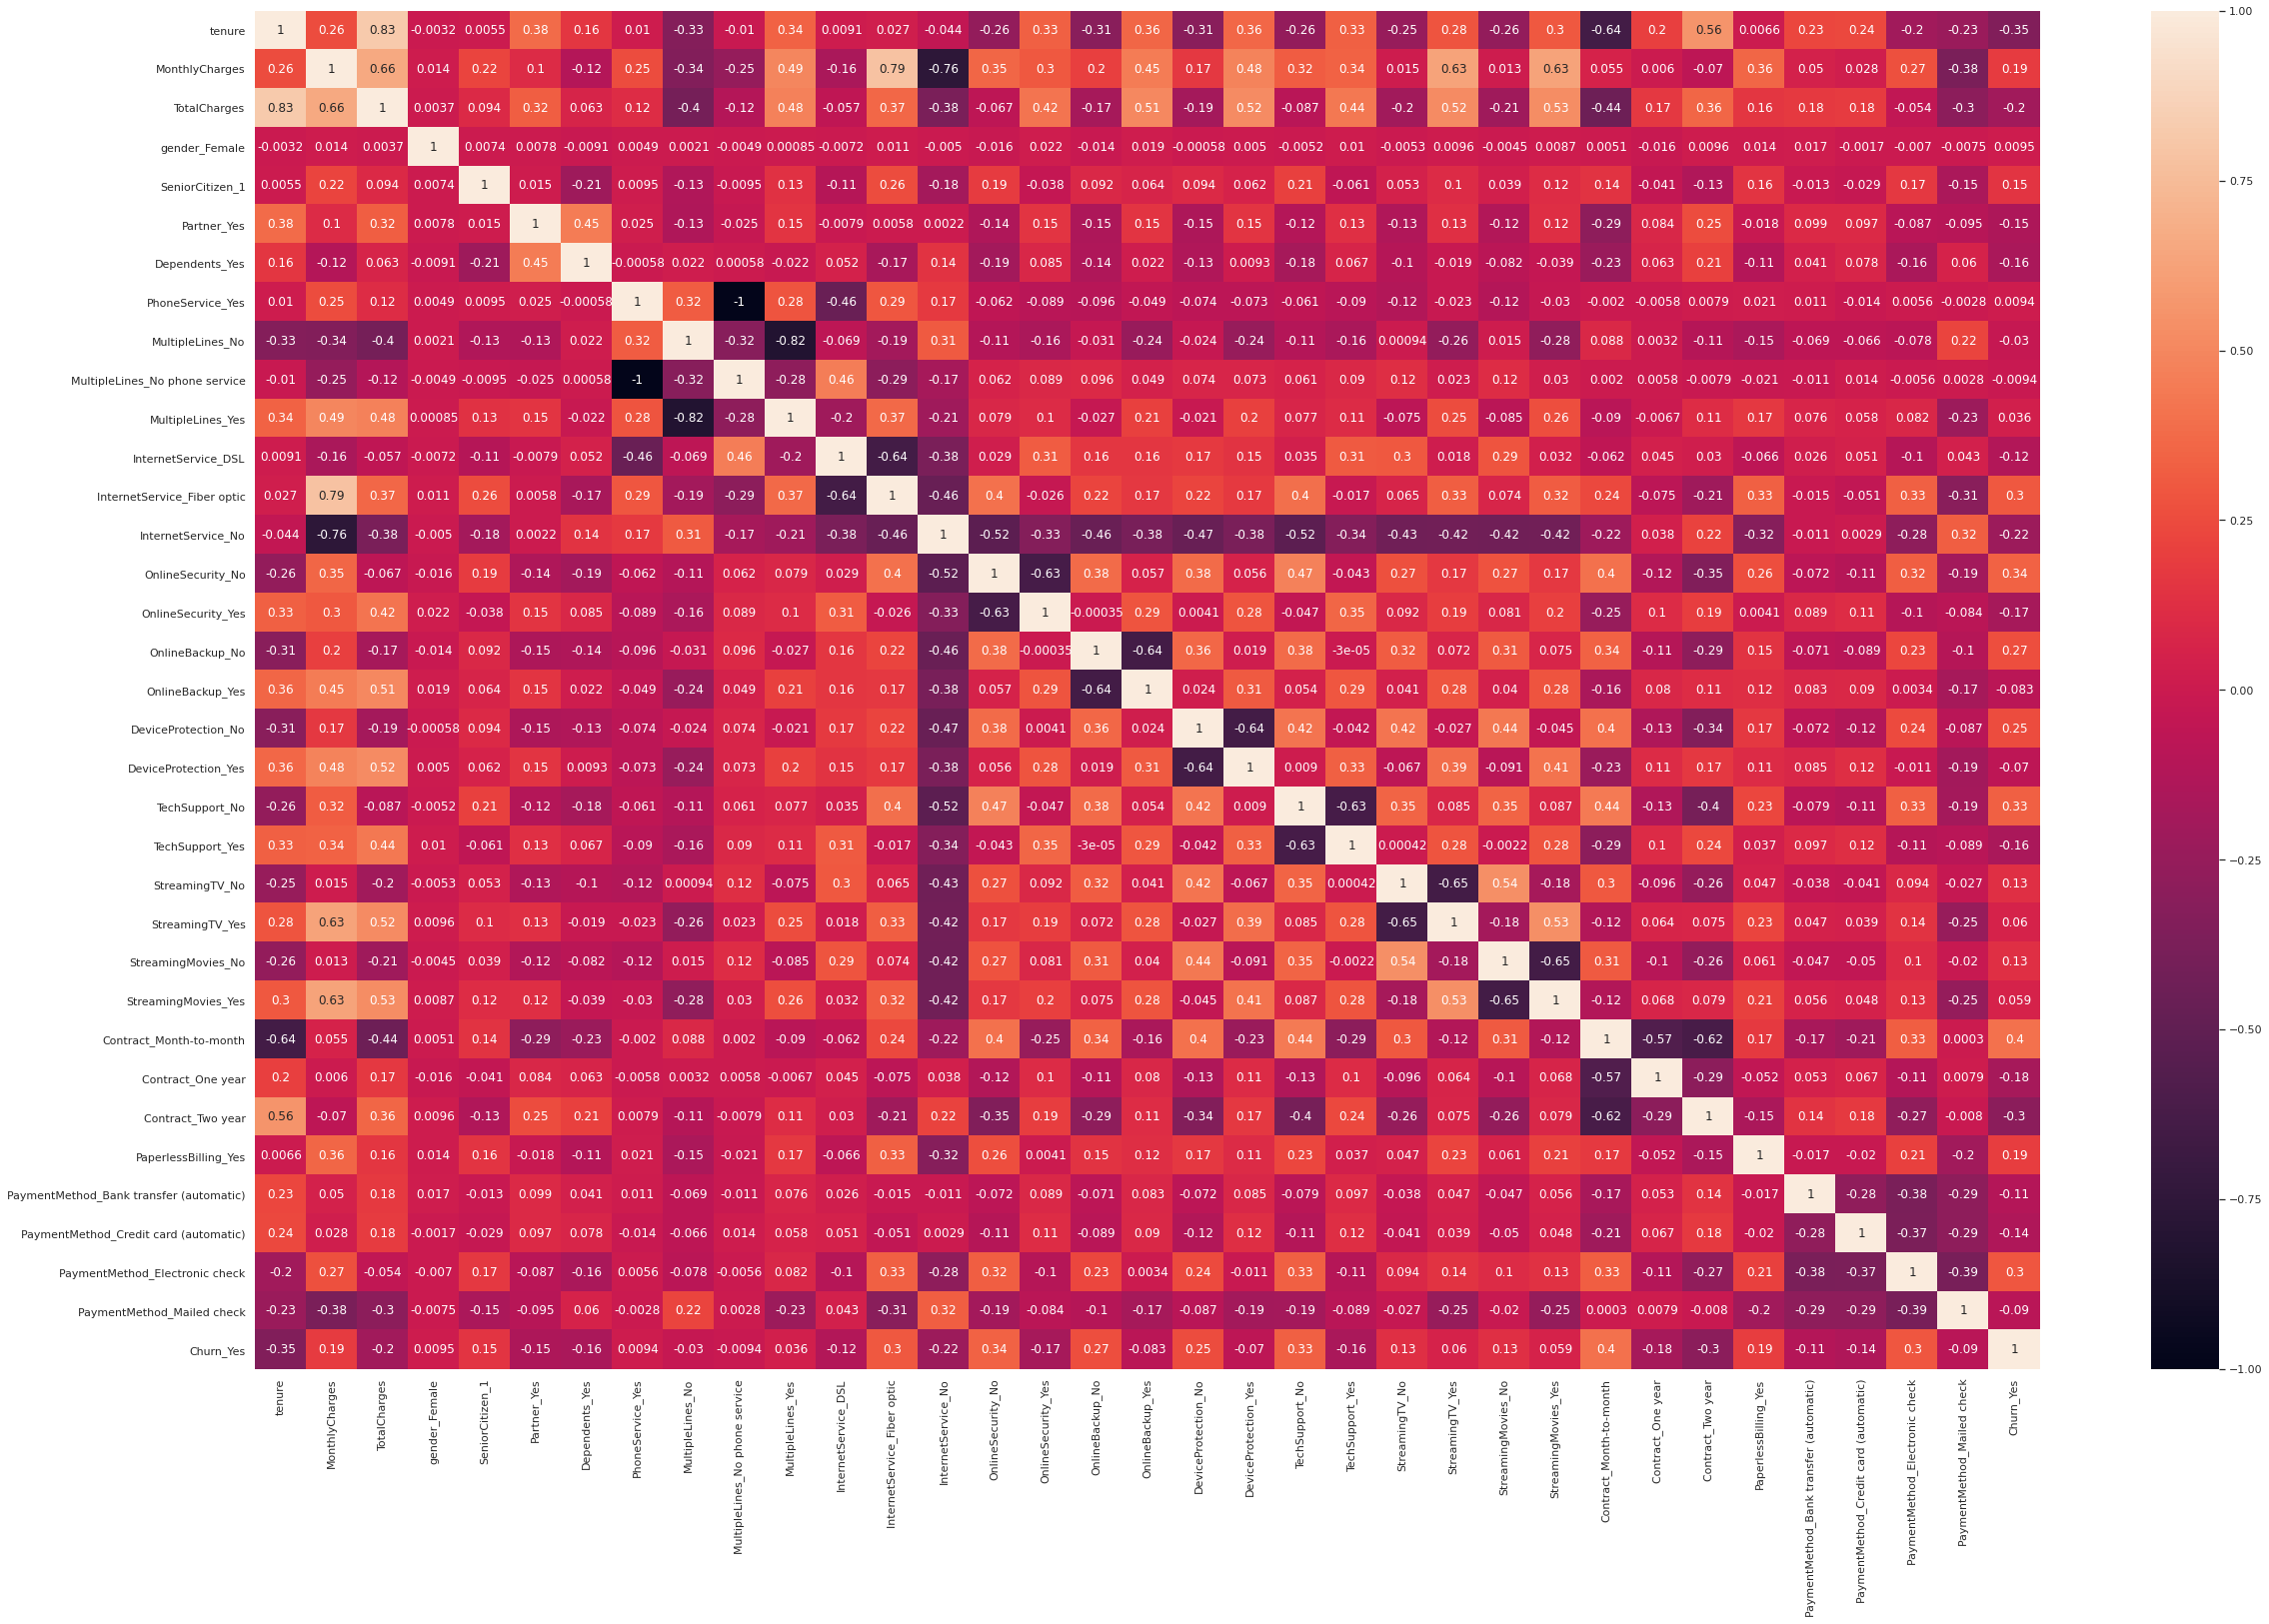

In [12]:
corMatrix = df_dummies.corr()
plt.figure(figsize=(40,25))
sns.heatmap(corMatrix,  annot = True)

In [13]:
corMatrix['Churn_Yes'].sort_values()

tenure                                    -0.348469
Contract_Two year                         -0.301906
InternetService_No                        -0.223860
TotalCharges                              -0.196390
Contract_One year                         -0.175855
OnlineSecurity_Yes                        -0.174301
TechSupport_Yes                           -0.161821
Dependents_Yes                            -0.160204
Partner_Yes                               -0.146840
PaymentMethod_Credit card (automatic)     -0.135232
InternetService_DSL                       -0.120394
PaymentMethod_Bank transfer (automatic)   -0.112447
PaymentMethod_Mailed check                -0.090066
OnlineBackup_Yes                          -0.082648
DeviceProtection_Yes                      -0.070000
MultipleLines_No                          -0.030357
MultipleLines_No phone service            -0.009421
PhoneService_Yes                           0.009421
gender_Female                              0.009548
MultipleLine

In [18]:
X = df_dummies.drop(['Churn_Yes'],axis = 1)
scaler = StandardScaler()
scaler.fit(X)
X1 = scaler.transform(X)

# Build Models and Make Prediction

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1320
           1       0.65      0.51      0.57       476

    accuracy                           0.80      1796
   macro avg       0.74      0.70      0.72      1796
weighted avg       0.78      0.80      0.79      1796



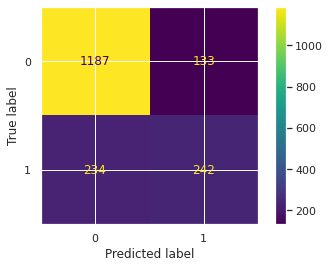

In [19]:

y = df_dummies.Churn_Yes
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=42,stratify =y)
lr = LogisticRegression(max_iter = 500,random_state = 42)
lr.fit(X_train,y_train)
plot_confusion_matrix(lr, X_test, y_test)
predy = lr.predict(X_test)
print(classification_report(y_test,predy))

In [21]:
features = pd.DataFrame(lr.coef_.transpose(),index = X.columns)
features.sort_values(by = 0, ascending = False)


,0
TotalCharges,0.517880
Contract_Month-to-month,0.333029
InternetService_Fiber optic,0.195971
PaperlessBilling_Yes,0.189017
OnlineSecurity_No,0.150279
PaymentMethod_Electronic check,0.134589
OnlineBackup_No,0.113061
SeniorCitizen_1,0.107824
TechSupport_No,0.101251
StreamingMovies_Yes,0.098820


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1320
           1       0.64      0.48      0.55       476

    accuracy                           0.79      1796
   macro avg       0.73      0.69      0.71      1796
weighted avg       0.78      0.79      0.78      1796



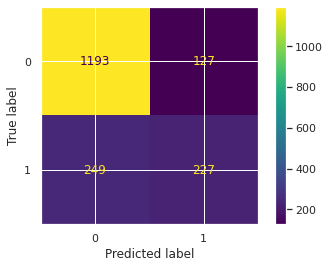

In [22]:
rfclf = RandomForestClassifier(n_estimators = 500,criterion = 'entropy',random_state = 42)
rfclf.fit(X_train,y_train)
plot_confusion_matrix(rfclf, X_test, y_test)
predy = rfclf.predict(X_test)
print(classification_report(y_test,predy))

In [23]:
features = pd.DataFrame(rfclf.feature_importances_,index = X.columns)
features.sort_values(by = 0, ascending = False)

,0
TotalCharges,0.163181
MonthlyCharges,0.147651
tenure,0.139425
Contract_Month-to-month,0.059796
OnlineSecurity_No,0.031931
gender_Female,0.028743
PaymentMethod_Electronic check,0.027590
PaperlessBilling_Yes,0.026475
Contract_Two year,0.024963
TechSupport_No,0.024343


              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1320
           1       0.63      0.52      0.57       476

    accuracy                           0.79      1796
   macro avg       0.73      0.70      0.71      1796
weighted avg       0.78      0.79      0.78      1796



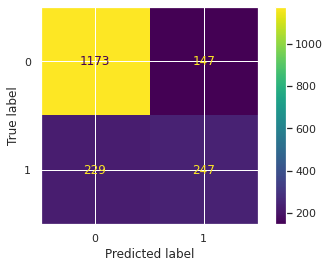

In [24]:
gbclf = GradientBoostingClassifier(n_estimators = 500,random_state = 42)
gbclf.fit(X_train,y_train)
plot_confusion_matrix(gbclf, X_test, y_test)
predy = gbclf.predict(X_test)
print(classification_report(y_test,predy))

In [25]:
features = pd.DataFrame(gbclf.feature_importances_,index = X.columns)
features.sort_values(by = 0, ascending = False)


,0
Contract_Month-to-month,0.282356
TotalCharges,0.209490
tenure,0.130278
MonthlyCharges,0.130123
OnlineSecurity_No,0.052495
InternetService_Fiber optic,0.041492
PaymentMethod_Electronic check,0.030751
TechSupport_No,0.016173
PaperlessBilling_Yes,0.015621
OnlineBackup_No,0.011536


LogisticRegression scored the best in overall accuracy, but GradientBoostingClassifier performed slightly better in terms of churn recall, and the top features are more aligned with what we observed in the EDA.